## Práctica 2. Computación Social y Personalización. Sistemas de recomendación.
#### Autores: Jaime Carrero Galisteo y Jesús Blázquez Bautista.

In [1]:
# Cargamos las librerías necesarias y algunos de nuestros métodos realizados
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
from KNN import KNN
from Matrix_factorization import Matrix_factorization, Matrix_factorization_bias
from Metrics import metrics
import json

### Tras recoger los datos en el notebook Obtencion_ratings.ipynb procedemos al análisis del mismo.

In [ ]:
# Cargamos el dataset
data = pd.read_csv('ratings_bien.csv', engine= 'python')
data.sort_values(by=('user_id'), inplace= True)
data.reset_index(inplace= True, drop= True)
data

,user_id,item_id,rating,timestamp
0,0,122339,5.0,1485216000
1,0,44777,4.0,1449360000
2,0,107972,5.0,1421280000
3,0,97552,5.0,1390262400
4,1,26825,5.0,1289865600
...,...,...,...,...
147131,1547,96038,5.0,1513209600
147132,1547,8286,5.0,1513900800
147133,1547,41056,5.0,1514160000
147134,1547,115290,5.0,1510963200


In [ ]:
NUM_USERS = data.user_id.nunique()
NUM_ITEMS = data.item_id.nunique()
NUM_RATINGS = len(data)

MIN_RATING = int(data.rating.min())
MAX_RATING = int(data.rating.max())

In [ ]:
print(f'El dataset está formado por {NUM_USERS} usuarios, {NUM_ITEMS} ítems y {NUM_RATINGS} votaciones.')
print(f'La puntuación mínima es de {MIN_RATING}, la puntuación máxima es de {MAX_RATING}.')
print(f'La puntuación media de las votaciones es de {data.rating.mean():.2f}.')

El dataset está formado por 1548 usuarios, 128877 ítems y 147136 votaciones.
La puntuación mínima es de 1, la puntuación máxima es de 5.
La puntuación media de las votaciones es de 4.67.


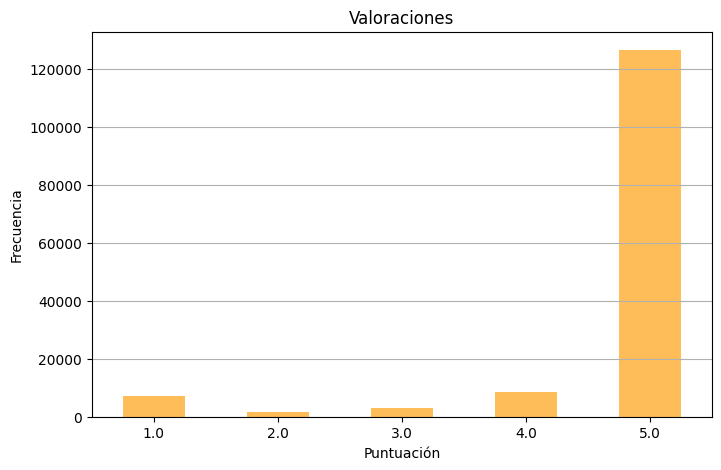

In [ ]:
frecuencias = data.rating.value_counts().sort_index()

# Gráfico de las valoraciones
plt.figure(figsize=(8, 5))
frecuencias.plot(kind='bar', color='#ffbd59')
plt.title("Valoraciones")
plt.xlabel("Puntuación")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

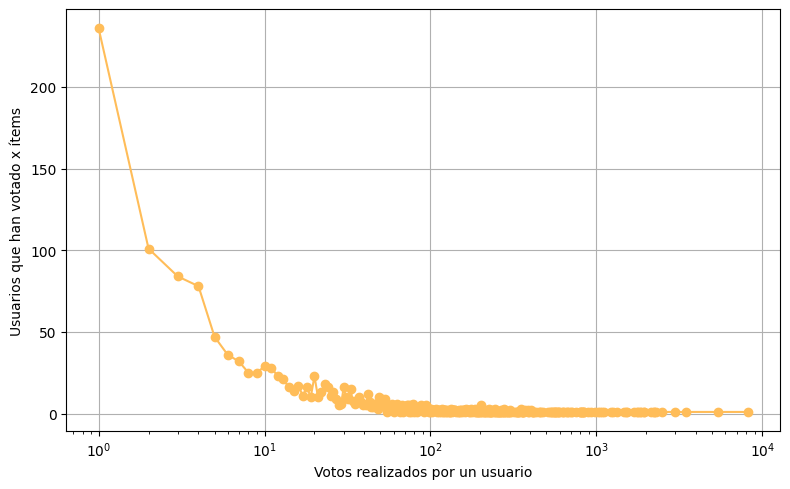

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

user_vote_counts = data['user_id'].value_counts()

# Paso 2: Contar cuántos usuarios tienen X cantidad de votos
vote_distribution = user_vote_counts.value_counts().sort_index()

# Paso 3: Hacer el plot
plt.figure(figsize=(8, 5))
plt.plot(vote_distribution.index, vote_distribution.values, marker='o', color='#ffbd59')
plt.xscale('log')
plt.xlabel('Votos realizados por un usuario')
plt.ylabel('Usuarios que han votado x ítems')
plt.grid(True)
plt.tight_layout()
plt.show()

En este gráfico podemos observar que la puntuación máxima de 5 es la que con más frecuencia aparece, seguida de 4 y 1.

In [ ]:
voto_users = data.user_id.value_counts()[:3].to_dict()
voto_items = data.item_id.value_counts()[:3].to_dict()

print(f'Los 3 usuarios que más ítems han votado han sido:')
for i, j in voto_users.items():
    print(f'Usuario {i} -> {j} votos')

print(f'\nLos 3 ítems que han recibido más votos han sido:')
for i, j in voto_items.items():
    print(f'Ítem {i} -> {j} votos')


Los 3 usuarios que más ítems han votado han sido:
Usuario 195 -> 8157 votos
Usuario 100 -> 5415 votos
Usuario 308 -> 3486 votos

Los 3 ítems que han recibido más votos han sido:
Ítem 3307 -> 39 votos
Ítem 28337 -> 31 votos
Ítem 91291 -> 26 votos


In [ ]:
votaciones_vacias = 100 - NUM_RATINGS / (NUM_ITEMS * NUM_USERS) * 100
print(f'El {votaciones_vacias:.2f}% de las posibles votaciones están vacías.')

El 99.93% de las posibles votaciones están vacías.


### Ahora vamos a comprobar que tal funciona el método de KNN.

#### Primero pasamos los datos a una matriz con filas usuarios, columnas ítems y los valores son el rating del usuario al ítem.

In [ ]:
X_train = data.sample(int(0.8 * data.shape[0]), random_state= 42)

In [ ]:
X_test = data.loc[np.setdiff1d(data.index, X_train.index), :]

In [ ]:
ratings = np.array([[np.nan] * data['item_id'].nunique()] * data['user_id'].nunique(), dtype= 'float32')
ratings = pd.DataFrame(ratings)
for i in range(X_train.shape[0]):
    rating = X_train.iloc[i]
    ratings.loc[rating['user_id'], rating['item_id']] = rating['rating']
ratings

,0,1,2,3,4,5,6,7,8,9,...,128867,128868,128869,128870,128871,128872,128873,128874,128875,128876
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_ratings = np.array([[np.nan] * data['item_id'].nunique()] * data['user_id'].nunique(), dtype= 'float32')
test_ratings = pd.DataFrame(test_ratings)
for i in range(X_test.shape[0]):
    rating = X_train.iloc[i]
    test_ratings.loc[rating['user_id'], rating['item_id']] = rating['rating']
test_ratings

,0,1,2,3,4,5,6,7,8,9,...,128867,128868,128869,128870,128871,128872,128873,128874,128875,128876
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Definimos esta función que usaremos más adelante
def to_json(dicc, name, pred= False):
    '''Función que sirve para pasar los datos de uno de los diccionarios generados por nuestros
    métodos de recomendación a un objeto json.'''

    if pred:
        new_dicc = {str((k[0], k[1])) : float(dicc[k]) if dicc[k] is not None else None for k in dicc.keys()}
    else:
        new_dicc = {int(k) : [int(dicc[k][i]) for i in range(len(dicc[k]))] for k in dicc.keys()}
    with open(name, 'w', encoding= 'utf-8') as f:
        json.dump(new_dicc, f, indent= 4)

#### Posteriormente pasamos a hacer las comprobaciones.

In [ ]:
knn = KNN(ratings.values, test_ratings.values)

In [ ]:
# Miramos las recomendaciones reales que se habrían hecho con los datos de test
true_recomendations_test = knn.get_recomendations(users= X_test['user_id'].unique(), test= True, pred= True)
to_json(true_recomendations_test, 'true_recomendations_test.json')

100%|██████████| 1188/1188 [00:00<00:00, 4128.17it/s]


In [ ]:
recomendations_test_wap_jsmd = knn.get_recomendations(users= X_test['user_id'].unique() ,pred= True)
to_json(recomendations_test_wap_jsmd, 'recomendations_test_wap_jsmd.json')
to_json(knn.predictions, 'predicciones_test_wap_jsmd.json', pred= True)

100%|██████████| 1188/1188 [14:54<00:00,  1.33it/s]


In [ ]:
recomendations_test_ap_jsmd = knn.get_recomendations(users= X_test['user_id'].unique() ,pred= True, ap= True)
to_json(recomendations_test_ap_jsmd, 'recomendations_test_ap_jsmd.json')
to_json(knn.predictions, 'predicciones_test_ap_jsmd.json', pred= True)

100%|██████████| 1188/1188 [13:09<00:00,  1.50it/s]


In [ ]:
recomendations_test_dpmf_jsmd = knn.get_recomendations(users= X_test['user_id'].unique() ,pred= True, dpmf= True)
to_json(recomendations_test_dpmf_jsmd, 'recomendations_test_dpmf_jsmd.json')
to_json(knn.predictions, 'predicciones_test_dpmf_jsmd.json', pred= True)

100%|██████████| 1188/1188 [18:32<00:00,  1.07it/s]


In [ ]:
recomendations_test_dpmf_corr = knn.get_recomendations(users= X_test['user_id'].unique() ,pred= True, dpmf= True, corr= True)
to_json(recomendations_test_dpmf_corr, 'recomendations_test_dpmf_corr.json')
to_json(knn.predictions, 'predicciones_test_dpmf_corr.json', pred= True)

100%|██████████| 1188/1188 [07:20<00:00,  2.70it/s]


In [ ]:
recomendations_test_dpmf_corr = knn.get_recomendations(users= X_test['user_id'].unique() ,pred= True, corr= True)
to_json(recomendations_test_dpmf_corr, 'recomendations_test_wap_corr.json')
to_json(knn.predictions, 'predicciones_test_wap_corr.json', pred= True)

100%|██████████| 1188/1188 [07:09<00:00,  2.77it/s]


In [ ]:
recomendations_test_dpmf_corr = knn.get_recomendations(users= X_test['user_id'].unique() ,pred= True, ap= True, corr= True)
to_json(recomendations_test_dpmf_corr, 'recomendations_test_ap_corr.json')
to_json(knn.predictions, 'predicciones_test_ap_corr.json', pred= True)

100%|██████████| 1188/1188 [07:03<00:00,  2.81it/s]


#### Comprobamos con las métricas que tal ha funcionado


In [ ]:
preds = ['predicciones_test_wap_jsmd.json', 'predicciones_test_ap_jsmd.json', 'predicciones_test_dpmf_jsmd.json',\
         'predicciones_test_wap_corr.json', 'predicciones_test_ap_corr.json', 'predicciones_test_dpmf_corr.json']
preds_names = ['wap_jsmd', 'ap_jsmd', 'dpmf_jsmd', 'wap_corr', 'ap_corr', 'dpmf_corr']

In [ ]:
metricas = metrics()
for i in range(len(preds)):
    with open(preds[i], 'r', encoding='utf-8') as f:
        predicciones = json.load(f)
        print(f'{preds_names[i]} mae: {metricas.get_mae(predicciones, X_test)}')
        print(f'{preds_names[i]} rmse: {metricas.get_rmse(predicciones, X_test)}')

wap_jsmd mae: (0.15753424657534246, 73)
wap_jsmd rmse: (0.2089041095890411, 73)
ap_jsmd mae: (0.15753424657534246, 73)
ap_jsmd rmse: (0.2089041095890411, 73)
dpmf_jsmd mae: (0.15753424657534246, 73)
dpmf_jsmd rmse: (0.2089041095890411, 73)
wap_corr mae: (0.15753424657534246, 73)
wap_corr rmse: (0.2089041095890411, 73)
ap_corr mae: (0.15753424657534246, 73)
ap_corr rmse: (0.2089041095890411, 73)
dpmf_corr mae: (0.15753424657534246, 73)
dpmf_corr rmse: (0.2089041095890411, 73)


In [ ]:
recs = ['recomendations_test_ap_corr.json', 'recomendations_test_ap_jsmd.json', 'recomendations_test_dpmf_corr.json',\
        'recomendations_test_dpmf_jsmd.json', 'recomendations_test_wap_corr.json', 'recomendations_test_wap_jsmd.json']
recs_names = ['ap_corr', 'ap_jsmd', 'dpmf_corr', 'dmpf_jsmd', 'wap_corr', 'wap_jsmd']
with open('true_recomendations_test.json', 'r', encoding='utf-8') as f:
    true_recomendations_test = json.load(f)

In [ ]:
metricas = metrics()
for i in range(len(recs)):
    with open(recs[i], 'r', encoding='utf-8') as f:
        recomendaciones = json.load(f)
        print(f'{recs_names[i]} precisión: {metricas.precision(true_recomendations_test, recomendaciones)}')
        print(f'{recs_names[i]} recall: {metricas.recall(true_recomendations_test, recomendaciones)}')
        print(f'{recs_names[i]} F1: {metricas.f1(true_recomendations_test, recomendaciones)}')

ap_corr precisión: 0.05260739719733517
ap_corr recall: 0.05260739719733517
ap_corr F1: 0.05260739719733517
ap_jsmd precisión: 0.05812083620491615
ap_jsmd recall: 0.05812083620491615
ap_jsmd F1: 0.05812083620491615
dpmf_corr precisión: 0.03009418791637951
dpmf_corr recall: 0.03009418791637951
dpmf_corr F1: 0.03009418791637951
dmpf_jsmd precisión: 0.03308063404548587
dmpf_jsmd recall: 0.03308063404548587
dmpf_jsmd F1: 0.03308063404548587
wap_corr precisión: 0.028715828164484265
wap_corr recall: 0.028715828164484265
wap_corr F1: 0.028715828164484265
wap_jsmd precisión: 0.03170227429359063
wap_jsmd recall: 0.03170227429359063
wap_jsmd F1: 0.03170227429359063


### A continuación seguimos con la Factorización Matricial.

#### Primero sin bias.

Miramos cual es el número de factores latentes que minimiza el mae.

In [ ]:
Num_factors = np.arange(3,20)
metricas = metrics()
mae = []
f1 = []
for nf in Num_factors:
    
    MF = Matrix_factorization(ratings.values, test_ratings.values, nf, 0.0001, 0.2)
    MF.train(50)

    # Calculamos las predicciones
    predictions = {}
    for i in range(X_test.shape[0]):
        linea = X_test.iloc[i]
        predictions[f'({int(linea["user_id"])}, {int(linea["item_id"])})'] = MF.compute_prediction(int(linea["user_id"]), int(linea["item_id"]))

    # Calculamos el mae y lo añadimos a la lista
    mae.append(metricas.get_mae(predictions, X_test)[0])
    print(metricas.get_mae(predictions, X_test))

    # Calculamos las recomendaciones
    mf_recomendations = MF.get_recommendations(N= 5, pred= True, users= X_test['user_id'].unique())

    # Calcualmos el f1
    f1.append(metricas.f1(true_recomendations_test, mf_recomendations))


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(2.166263558909998, 29428)


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


(1.8979841541336786, 29428)


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


(1.7007034539079406, 29428)


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


(1.5400350503445204, 29428)


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


(1.4177467111688584, 29428)


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


(1.326398265115507, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


(1.2307443712712, 29428)


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


(1.1658144171851341, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(1.1504126690973435, 29428)


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


(1.0577299806288638, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(1.0096210375502217, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(0.9967964964553184, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(1.0149976127195397, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


(1.0734932813681035, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(1.1752729477372452, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


(1.298584009253579, 29428)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


(1.518356643685241, 29428)


100%|██████████| 1188/1188 [00:00<00:00, 15976.76it/s]


Graficamos el MAE y el F1 con respecto al número de factores latentes.

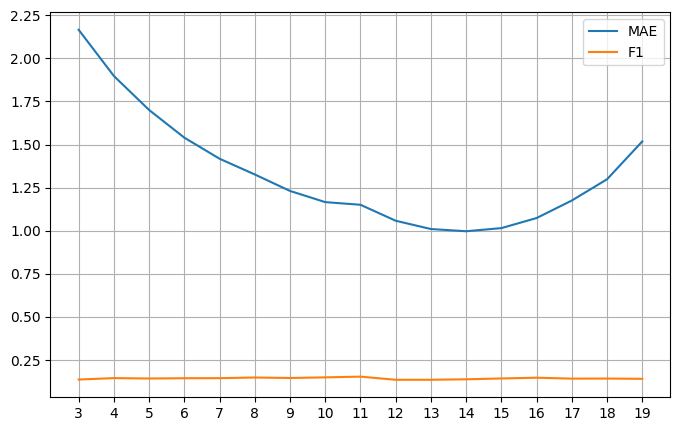

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(Num_factors, mae, label='MAE')
plt.plot(Num_factors, f1, label='F1')

plt.xticks(Num_factors)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
print(f'El mejor número de factores latentes es {Num_factors[mae.index(min(mae))]}')

El mejor número de factores latentes es 14


Una vez que tenemos el mejor número de factores latentes miramos más métricas a parte del MAE y del F1.

In [ ]:
MF = Matrix_factorization(ratings.values, test_ratings.values, 14, 0.0001, 0.2)

In [ ]:
MF.train(50)

100%|██████████| 50/50 [02:46<00:00,  3.34s/it]


In [ ]:
predictions = {}
for i in range(X_test.shape[0]):
    linea = X_test.iloc[i]
    predictions[f'({int(linea["user_id"])}, {int(linea["item_id"])})'] = MF.compute_prediction(int(linea["user_id"]), int(linea["item_id"]))
#to_json(predictions, 'predicciones_test_MF.json', pred= True)

In [ ]:
metricas = metrics()

In [ ]:
print(f'MAE: {metricas.get_mae(predictions, X_test)}')
print(f'RMSE: {metricas.get_rmse(predictions, X_test)}')

MAE: (0.9943176083093934, 29428)
RMSE: (1.6453485696725536, 29428)


In [ ]:
mf_recomendations = MF.get_recommendations(N= 5, pred= True, users= X_test['user_id'].unique())
to_json(mf_recomendations, 'recomendations_test_mf.json')

In [ ]:
print(f'Precisión: {metricas.precision(true_recomendations_test, mf_recomendations)}')
print(f'Recall: {metricas.recall(true_recomendations_test, mf_recomendations)}')
print(f'F1: {metricas.f1(true_recomendations_test, mf_recomendations)}')

Precisión: 0.1438
Recall: 0.1438
F1: 0.1438


#### A continuación probamos con los bias.

Miramos cual es el número de factores latentes que minimiza el mae.

In [ ]:
Num_factors = np.arange(3,15)
metricas = metrics()
mae = []
f1 = []
for nf in Num_factors:
    
    MFb = Matrix_factorization_bias(ratings.values, test_ratings.values, nf, 0.0001, 0.2)
    MFb.train(50)

    # Calculamos las predicciones
    predictions = {}
    for i in range(X_test.shape[0]):
        linea = X_test.iloc[i]
        predictions[f'({int(linea["user_id"])}, {int(linea["item_id"])})'] = MFb.compute_prediction(int(linea["user_id"]), int(linea["item_id"]))

    # Calculamos el mae y lo añadimos a la lista
    mae.append(metricas.get_mae(predictions, X_test)[0])
    print(metricas.get_mae(predictions, X_test))

    # Calculamos las recomendaciones
    mf_recomendations = MFb.get_recommendations(N= 5, pred= True, users= X_test['user_id'].unique())

    # Calcualmos el f1
    f1.append(metricas.f1(true_recomendations_test, mf_recomendations))


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


(0.6942332484294026, 29428)


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


(0.7153431405817786, 29428)


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


(0.7346736177414935, 29428)


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


(0.7529089113831074, 29428)


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


(0.763132039651995, 29428)


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


(0.7995499912014642, 29428)


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


(0.8017367475983365, 29428)


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


(0.8160651033109203, 29428)


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


(0.8315196571030927, 29428)


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


(0.8430446059097838, 29428)


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


(0.8541130868240112, 29428)


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


(0.8755324935331144, 29428)


100%|██████████| 1188/1188 [00:00<00:00, 14046.16it/s]


Graficamos el MAE y el F1 con respecto al número de factores latentes.

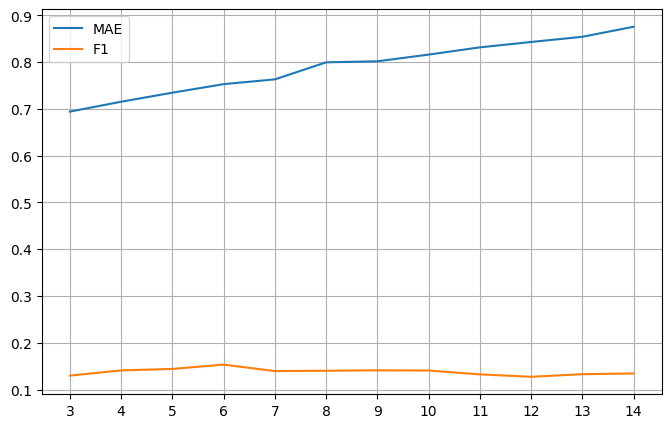

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(Num_factors, mae, label='MAE')
plt.plot(Num_factors, f1, label='F1')

plt.xticks(Num_factors)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
print(f'El mejor número de factores latentes es {Num_factors[mae.index(min(mae))]}')

El mejor número de factores latentes es 3


Una vez que tenemos el mejor número de factores latentes miramos más métricas a parte del MAE y del F1.

In [ ]:
MFb = Matrix_factorization_bias(ratings.values, test_ratings.values, 3, 0.0001, 0.2) # 4, 0.0001, 0.2

In [ ]:
MFb.train(50)

100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


In [ ]:
predictions = {}
for i in range(X_test.shape[0]):
    linea = X_test.iloc[i]
    predictions[f'({int(linea["user_id"])}, {int(linea["item_id"])})'] = MFb.compute_prediction(int(linea["user_id"]), int(linea["item_id"]))
#to_json(predictions, 'predicciones_test_MF.json', pred= True)

In [ ]:
metricas = metrics()

In [ ]:
print(f'MAE: {metricas.get_mae(predictions, X_test)}')
print(f'RMSE: {metricas.get_rmse(predictions, X_test)}')

MAE: (0.6395220241808965, 29428)
RMSE: (1.1858256219112409, 29428)


In [ ]:
mfb_recomendations = MFb.get_recommendations(N= 5, pred= True, users= X_test['user_id'].unique())
#to_json(mfb_recomendations, 'recomendations_test_mfb.json')

100%|██████████| 1188/1188 [00:00<00:00, 14039.95it/s]


In [ ]:
print(f'Precisión: {metricas.precision(true_recomendations_test, mfb_recomendations)}')
print(f'Recall: {metricas.recall(true_recomendations_test, mfb_recomendations)}')
print(f'F1: {metricas.f1(true_recomendations_test, mfb_recomendations)}')

Precisión: 0.1406
Recall: 0.1406
F1: 0.1406


## Bernouilli Matrix Factorization

Dado que este método requiere una mayor potencia computacional que los anteriores, vamos a reducir el dataset para facilitar los cálculos.

In [ ]:
# Cargamos el dataset
data = pd.read_csv('ratings_bien.csv', engine= 'python')
data.sort_values(by=('user_id'), inplace= True)
data.reset_index(inplace= True, drop= True)
data

,user_id,item_id,rating,timestamp
0,0,107972,5.0,1421280000
1,0,97552,5.0,1390262400
2,0,44777,4.0,1449360000
3,0,122339,5.0,1485216000
4,1,26825,5.0,1289865600
...,...,...,...,...
147131,1547,26621,5.0,1473465600
147132,1547,54943,5.0,1473811200
147133,1547,39991,5.0,1474416000
147134,1547,113315,5.0,1533254400


In [ ]:
# Usamos la mitad de las votaciones del dataset
data = data.iloc[:(len(data) // 2)]

# Mapeamos los ids de usuarios e ítems para que vayan de 0 a N - 1
user_map = {old: new for new, old in enumerate(data['user_id'].unique())}
item_map = {old: new for new, old in enumerate(data['item_id'].unique())}

# Aplicar el mapeo
data['user_id'] = data['user_id'].map(user_map)
data['item_id'] = data['item_id'].map(item_map)

C:\Users\jcarr\AppData\Local\Temp\ipykernel_13556\2813850836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['user_id'] = data['user_id'].map(user_map)
C:\Users\jcarr\AppData\Local\Temp\ipykernel_13556\2813850836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['item_id'] = data['item_id'].map(item_map)


In [ ]:
NUM_USERS = data['user_id'].nunique()
NUM_ITEMS = data['item_id'].nunique()
NUM_RATINGS = len(data)

MIN_RATING = data.rating.min()
MAX_RATING = data.rating.max()

Ahora vamos a dividir el dataset en dos matrices de votaciones y votaciones de test.

In [ ]:
# Dividimos en 80% para entrenamiento, 20% para test
X_train = data.sample(int(0.8 * data.shape[0]), random_state= 42)
X_test = data.loc[np.setdiff1d(data.index, X_train.index), :]


In [ ]:
ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

for idx, row in X_train.iterrows():
    u, i, rating = row['user_id'], row['item_id'], row['rating']
    ratings[int(u)][int(i)] = int(rating)

In [ ]:
test_ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

for idx, row in X_test.iterrows():
    u, i, rating = row['user_id'], row['item_id'], row['rating']
    test_ratings[int(u)][int(i)] = int(rating)

Una vez divido el dataset en entrenamiento y test, vamos a pasar a probar los diferentes métodos:

In [ ]:
N = 5

In [ ]:
def get_recommendations (predictions):
  recommendations = [None for _ in range(N)]

  for n in range(N):

    max_value = 0
    item = None

    for i, value in enumerate(predictions):
      if i not in recommendations and value != None and value > max_value:
        max_value = value
        item = i

    recommendations[n] = item

  return recommendations

In [ ]:
def get_user_mae (u, predictions):
  mae = 0
  count = 0

  for i in range(NUM_ITEMS):
    if test_ratings[u][i] != None and predictions[u][i] != None:
      mae += abs(test_ratings[u][i] - predictions[u][i])
      count += 1

  if count > 0:
    return mae / count
  else:
    return None


def get_mae (predictions):
  mae = 0
  count = 0

  for u in range(NUM_USERS):
    user_mae = get_user_mae(u, predictions)

    if user_mae != None:
      mae += user_mae
      count += 1

  if count > 0:
    return mae / count
  else:
    return None

In [ ]:
def get_user_rmse (u, predictions):
  mse = 0
  count = 0

  for i in range(NUM_ITEMS):
    if test_ratings[u][i] != None and predictions[u][i] != None:
      mse += (test_ratings[u][i] - predictions[u][i]) * (test_ratings[u][i] - predictions[u][i])
      count += 1

  if count > 0:
    return math.sqrt(mse / count)
  else:
    return None
  

def get_rmse (predictions):
  rmse = 0
  count = 0

  for u in range(NUM_USERS):
    user_rmse = get_user_rmse(u, predictions)

    if user_rmse != None:
      rmse += user_rmse
      count += 1


  if count > 0:
    return rmse / count
  else:
    return None

In [ ]:
theta = 4

In [ ]:
def get_user_precision (u, predictions):
  precision = 0
  count = 0
  recommendations = get_recommendations(predictions[u])

  for i in recommendations:
    if i != None and test_ratings[u][i] != None:
      precision += 1 if test_ratings[u][i] >= theta else 0
      count += 1

  if count > 0:
    return precision / count
  else:
    return None


def get_precision (predictions):
  precision = 0
  count = 0

  for u in range(NUM_USERS):
    user_precision = get_user_precision(u, predictions)

    if user_precision != None:
      precision += user_precision
      count += 1


  if count > 0:
    return precision / count
  else:
    return None

In [ ]:
def get_user_recall (u, predictions):
  recall = 0
  count = 0
  recommendations = get_recommendations(predictions[u])

  for i in range(NUM_ITEMS):
    if test_ratings[u][i] != None and predictions[u][i] != None:
      if test_ratings[u][i] >= theta:
        recall += 1 if i in recommendations else 0
        count += 1

  if count > 0:
    return recall / count
  else:
    return None


def get_recall (predictions):
  recall = 0
  count = 0

  for u in range(NUM_USERS):
    user_recall = get_user_recall(u, predictions)

    if user_recall != None:
      recall += user_recall
      count += 1


  if count > 0:
    return recall / count
  else:
    return None

In [ ]:
def get_user_f1 (u, predictions):
  precision = get_user_precision(u, predictions)
  recall = get_user_recall(u, predictions)

  if precision == None or recall == None:
    return None
  elif precision == 0 and recall == 0:
    return 0
  else:
    return 2 * precision * recall / (precision + recall)


def get_f1 (predictions):
  f1 = 0
  count = 0

  for u in range(NUM_USERS):
    user_f1 = get_user_f1(u, predictions)

    if user_f1 != None:
      f1 += user_f1
      count += 1


  if count > 0:
    return f1 / count
  else:
    return None

In [ ]:
def get_ordered_test_items(u):
    scores = [r if r is not None else float('-inf') for r in test_ratings[u]]
    items = np.argsort(scores)[::-1]
    return [i for i in items if scores[i] != float('-inf')]

In [ ]:
def get_user_idcg (u):
  items = get_ordered_test_items(u)
  idcg = 0

  for pos, i in enumerate(items):
    idcg += (2 ** test_ratings[u][i] - 1) / math.log(pos+2, 2)

  return idcg


def get_user_dcg (u, recommendations):
  dcg = 0

  for pos, i in enumerate(recommendations):
    if i != None and test_ratings[u][i] != None:
      dcg += (2 ** test_ratings[u][i] - 1) / math.log(pos+2, 2)

  return dcg


def get_user_ndcg (u, predictions):
  recommendations = get_recommendations(predictions[u])
  dcg = get_user_dcg(u, recommendations)
  idcg = get_user_idcg(u)
  if idcg == 0:
    return 0
  else:
    return dcg / idcg


def get_ndcg (predictions):
  ndcg = 0
  count = 0

  for u in range(NUM_USERS):
    user_ndcg = get_user_ndcg(u, predictions)

    if user_ndcg != None:
      ndcg += user_ndcg
      count += 1


  if count > 0:
    return ndcg / count
  else:
    return None

In [ ]:
MIN_RATING = 1
MAX_RATING = 5

SCORES = [1, 2, 3, 4, 5]

NUM_FACTORS = 7
LEARNING_RATE = 0.001
REGULARIZATION = 0.1

In [ ]:
random.seed(1)
U = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_USERS)] for _ in range(len(SCORES))]
V = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_ITEMS)] for _ in range(len(SCORES))]

In [ ]:
def logit (x):
  return 1 / (1 + math.exp(-x))

In [ ]:
def compute_prediction (u, i):
  prediction = None
  prob = 0
  for s in range(len(SCORES)):
    dot = np.dot(U[s][u], V[s][i])
    if logit(dot) > prob:
      prob = logit(dot)
      prediction = SCORES[s]
  return prediction, prob

Vamos a realizar una primera prueba para evaluar los resultados obtenidos:

In [ ]:
NUM_ITERATIONS = 10

In [ ]:
for it in range(NUM_ITERATIONS):
  print("Iteración " + str(it + 1) + " de " + str(NUM_ITERATIONS))

  for s in range(len(SCORES)):

    # update users
    for u in range(NUM_USERS):
      delta = np.zeros(NUM_FACTORS)
      for i in range(NUM_ITEMS):
        if ratings[u][i] != None:
          dot = np.dot(U[s][u], V[s][i])

          for f in range(NUM_FACTORS):
            if ratings[u][i] == SCORES[s]:
              delta[f] += (1 - logit(dot)) * V[s][i][f]
            else:
              delta[f] -= logit(dot) * V[s][i][f]

          for f in range(NUM_FACTORS):
            U[s][u][f] += LEARNING_RATE * (delta[f] - REGULARIZATION * U[s][u][f])

    # update items
    for i in range(NUM_ITEMS):
      theta = np.zeros(NUM_FACTORS)
      for u in range(NUM_USERS):
        if ratings[u][i] != None:
          dot = np.dot(U[s][u], V[s][i])

          for f in range(NUM_FACTORS):
            if ratings[u][i] == SCORES[s]:
              theta[f] += (1 - logit(dot)) * U[s][u][f]
            else:
              theta[f] -= logit(dot) * U[s][u][f]

          for f in range(NUM_FACTORS):
            V[s][i][f] += LEARNING_RATE * (theta[f] - REGULARIZATION * V[s][i][f])


Iteración 1 de 10
Iteración 2 de 10
Iteración 3 de 10
Iteración 4 de 10
Iteración 5 de 10
Iteración 6 de 10
Iteración 7 de 10
Iteración 8 de 10
Iteración 9 de 10
Iteración 10 de 10


In [ ]:
predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

# Rellenamos la matriz de predicciones
for u in range(NUM_USERS):
  for i in range(NUM_ITEMS):
    if test_ratings[u][i] != None:
      pred, prob = compute_prediction(u, i)
      predictions[u][i] = pred

In [ ]:
theta = 4

mae = get_mae(predictions)
rmse = get_rmse(predictions)
precision = get_precision(predictions)
recall = get_recall(predictions)
f1 = get_f1(predictions)
ndcg = get_ndcg(predictions)
print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))
print("nDCG = " + str(ndcg))

MAE = 0.7555210792869627
RMSE = 1.1017989001900144
Precision = 0.9148380355276912
Recall = 0.5617535057689764
F1 = 0.6057118273164367
nDCG = 0.5085099642836962


Vamos a intentar optimizar los parámetros del modelo de Bernouilli Matrix Factorization.

### Número de factores latentes

In [ ]:
list_mae = []
list_f1 = []
NUM_ITERATIONS = 5

for NUM_FACTORS in list(range(4, 11)):
    random.seed(1)
    U = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_USERS)] for _ in range(len(SCORES))]
    V = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_ITEMS)] for _ in range(len(SCORES))]


    for it in range(NUM_ITERATIONS):
        print("Iteración " + str(it + 1) + " de " + str(NUM_ITERATIONS))

        for s in range(len(SCORES)):

            # update users
            for u in range(NUM_USERS):
                delta = np.zeros(NUM_FACTORS)
                for i in range(NUM_ITEMS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                delta[f] += (1 - logit(dot)) * V[s][i][f]
                            else:
                                delta[f] -= logit(dot) * V[s][i][f]

                        for f in range(NUM_FACTORS):
                            U[s][u][f] += LEARNING_RATE * (delta[f] - REGULARIZATION * U[s][u][f])

            # update items
            for i in range(NUM_ITEMS):
                theta = np.zeros(NUM_FACTORS)
                for u in range(NUM_USERS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                theta[f] += (1 - logit(dot)) * U[s][u][f]
                            else:
                                theta[f] -= logit(dot) * U[s][u][f]
                        for f in range(NUM_FACTORS):
                            V[s][i][f] += LEARNING_RATE * (theta[f] - REGULARIZATION * V[s][i][f])

    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    for u in range(NUM_USERS):
        for i in range(NUM_ITEMS):
            if test_ratings[u][i] != None:
                pred, prob = compute_prediction(u, i)
                predictions[u][i] = pred
    
    theta = 4
    mae = get_mae(predictions)
    list_mae.append(mae)
    f1 = get_f1(predictions)
    list_f1.append(f1)

Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5


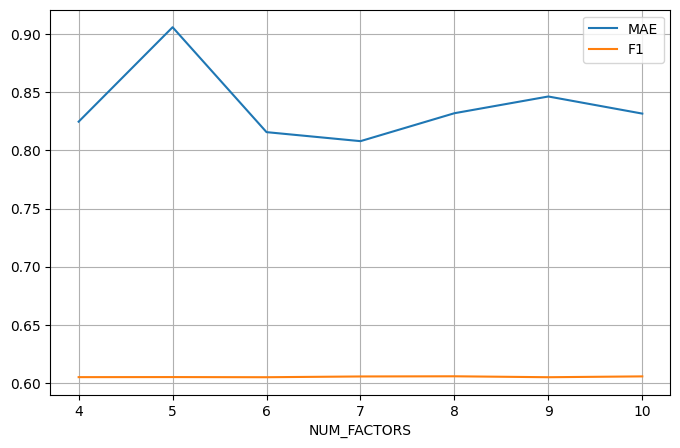

In [ ]:
x = list(range(4, 11))

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('NUM_FACTORS')
plt.legend()
plt.grid(True)

plt.show()

La F1 se mantiene igual mientras que el menor error MAE ocurre con 7 factores latentes. Luego, el modelo se optimiza en `NUM_FACTORES = 7`.

### Learning rate

In [ ]:
NUM_FACTORS = 7
REGULARIZATION = 0.1

In [ ]:
list_mae = []
list_f1 = []
NUM_ITERATIONS = 5

for LEARNING_RATE in [0.005, 0.007, 0.009, 0.01]:
    random.seed(1)
    U = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_USERS)] for _ in range(len(SCORES))]
    V = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_ITEMS)] for _ in range(len(SCORES))]


    for it in range(NUM_ITERATIONS):
        print("Iteración " + str(it + 1) + " de " + str(NUM_ITERATIONS))

        for s in range(len(SCORES)):

            # update users
            for u in range(NUM_USERS):
                delta = np.zeros(NUM_FACTORS)
                for i in range(NUM_ITEMS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                delta[f] += (1 - logit(dot)) * V[s][i][f]
                            else:
                                delta[f] -= logit(dot) * V[s][i][f]

                        for f in range(NUM_FACTORS):
                            U[s][u][f] += LEARNING_RATE * (delta[f] - REGULARIZATION * U[s][u][f])

            # update items
            for i in range(NUM_ITEMS):
                theta = np.zeros(NUM_FACTORS)
                for u in range(NUM_USERS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                theta[f] += (1 - logit(dot)) * U[s][u][f]
                            else:
                                theta[f] -= logit(dot) * U[s][u][f]
                        for f in range(NUM_FACTORS):
                            V[s][i][f] += LEARNING_RATE * (theta[f] - REGULARIZATION * V[s][i][f])

    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    for u in range(NUM_USERS):
        for i in range(NUM_ITEMS):
            if test_ratings[u][i] != None:
                pred, prob = compute_prediction(u, i)
                predictions[u][i] = pred
    
    theta = 4
    mae = get_mae(predictions)
    list_mae.append(mae)
    f1 = get_f1(predictions)
    list_f1.append(f1)

Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5


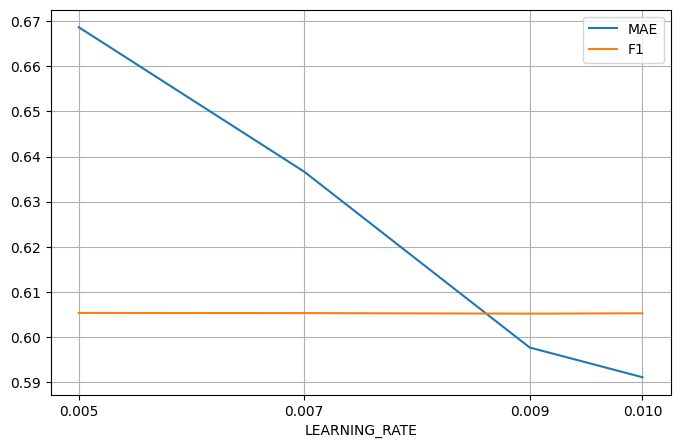

In [ ]:
x = [0.005, 0.007, 0.009, 0.01]

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('LEARNING_RATE')
plt.legend()
plt.grid(True)

plt.show()

A mayor learning rate, menor es el error. Por tanto, el modelo se optimiza en `LEARNING_RATE = 0.01`.

### Regularization

In [ ]:
NUM_FACTORS = 7
LEARNING_RATE = 0.01

In [ ]:
list_mae = []
list_f1 = []
NUM_ITERATIONS = 5

for REGULARIZATION in [0.3, 0.5, 0.7, 0.9]:
    random.seed(1)
    U = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_USERS)] for _ in range(len(SCORES))]
    V = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_ITEMS)] for _ in range(len(SCORES))]


    for it in range(NUM_ITERATIONS):
        print("Iteración " + str(it + 1) + " de " + str(NUM_ITERATIONS))

        for s in range(len(SCORES)):

            # update users
            for u in range(NUM_USERS):
                delta = np.zeros(NUM_FACTORS)
                for i in range(NUM_ITEMS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                delta[f] += (1 - logit(dot)) * V[s][i][f]
                            else:
                                delta[f] -= logit(dot) * V[s][i][f]

                        for f in range(NUM_FACTORS):
                            U[s][u][f] += LEARNING_RATE * (delta[f] - REGULARIZATION * U[s][u][f])

            # update items
            for i in range(NUM_ITEMS):
                theta = np.zeros(NUM_FACTORS)
                for u in range(NUM_USERS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                theta[f] += (1 - logit(dot)) * U[s][u][f]
                            else:
                                theta[f] -= logit(dot) * U[s][u][f]
                        for f in range(NUM_FACTORS):
                            V[s][i][f] += LEARNING_RATE * (theta[f] - REGULARIZATION * V[s][i][f])

    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    for u in range(NUM_USERS):
        for i in range(NUM_ITEMS):
            if test_ratings[u][i] != None:
                pred, prob = compute_prediction(u, i)
                predictions[u][i] = pred
    
    theta = 4
    mae = get_mae(predictions)
    list_mae.append(mae)
    f1 = get_f1(predictions)
    list_f1.append(f1)

Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5
Iteración 1 de 5
Iteración 2 de 5
Iteración 3 de 5
Iteración 4 de 5
Iteración 5 de 5


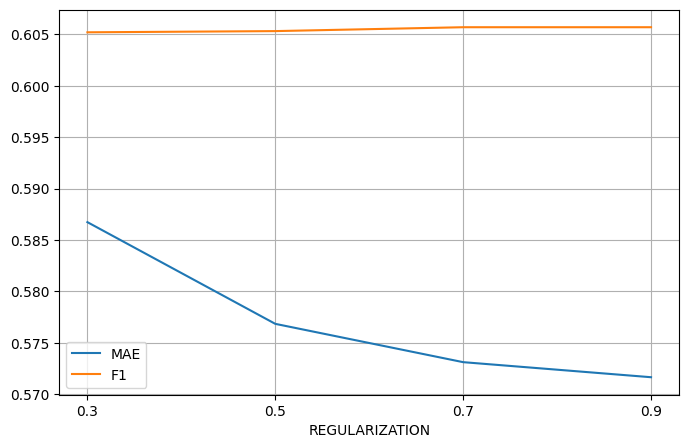

In [ ]:
x = [0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('REGULARIZATION')
plt.legend()
plt.grid(True)

plt.show()

Obtenemos los mejores resultados con `REGULARIZATION = 0.9`.

### Número de iteraciones

In [ ]:
NUM_FACTORS = 7
LEARNING_RATE = 0.01
REGULARIZATION = 0.9

In [ ]:
list_mae = []
list_f1 = []

for NUM_ITERATIONS in [10, 20, 30]:
    random.seed(1)
    U = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_USERS)] for _ in range(len(SCORES))]
    V = [[[random.random() for _ in range(NUM_FACTORS)] for _ in range(NUM_ITEMS)] for _ in range(len(SCORES))]


    for it in range(NUM_ITERATIONS):
        print("Iteración " + str(it + 1) + " de " + str(NUM_ITERATIONS))

        for s in range(len(SCORES)):

            # update users
            for u in range(NUM_USERS):
                delta = np.zeros(NUM_FACTORS)
                for i in range(NUM_ITEMS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                delta[f] += (1 - logit(dot)) * V[s][i][f]
                            else:
                                delta[f] -= logit(dot) * V[s][i][f]

                        for f in range(NUM_FACTORS):
                            U[s][u][f] += LEARNING_RATE * (delta[f] - REGULARIZATION * U[s][u][f])

            # update items
            for i in range(NUM_ITEMS):
                theta = np.zeros(NUM_FACTORS)
                for u in range(NUM_USERS):
                    if ratings[u][i] != None:
                        dot = np.dot(U[s][u], V[s][i])

                        for f in range(NUM_FACTORS):
                            if ratings[u][i] == SCORES[s]:
                                theta[f] += (1 - logit(dot)) * U[s][u][f]
                            else:
                                theta[f] -= logit(dot) * U[s][u][f]
                        for f in range(NUM_FACTORS):
                            V[s][i][f] += LEARNING_RATE * (theta[f] - REGULARIZATION * V[s][i][f])

    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    for u in range(NUM_USERS):
        for i in range(NUM_ITEMS):
            if test_ratings[u][i] != None:
                pred, prob = compute_prediction(u, i)
                predictions[u][i] = pred
    
    theta = 4
    mae = get_mae(predictions)
    list_mae.append(mae)
    f1 = get_f1(predictions)
    list_f1.append(f1)

Iteración 1 de 10
Iteración 2 de 10
Iteración 3 de 10
Iteración 4 de 10
Iteración 5 de 10
Iteración 6 de 10
Iteración 7 de 10
Iteración 8 de 10
Iteración 9 de 10
Iteración 10 de 10
Iteración 1 de 20
Iteración 2 de 20
Iteración 3 de 20
Iteración 4 de 20
Iteración 5 de 20
Iteración 6 de 20
Iteración 7 de 20
Iteración 8 de 20
Iteración 9 de 20
Iteración 10 de 20
Iteración 11 de 20
Iteración 12 de 20
Iteración 13 de 20
Iteración 14 de 20
Iteración 15 de 20
Iteración 16 de 20
Iteración 17 de 20
Iteración 18 de 20
Iteración 19 de 20
Iteración 20 de 20
Iteración 1 de 30
Iteración 2 de 30
Iteración 3 de 30
Iteración 4 de 30
Iteración 5 de 30
Iteración 6 de 30
Iteración 7 de 30
Iteración 8 de 30
Iteración 9 de 30
Iteración 10 de 30
Iteración 11 de 30
Iteración 12 de 30
Iteración 13 de 30
Iteración 14 de 30
Iteración 15 de 30
Iteración 16 de 30
Iteración 17 de 30
Iteración 18 de 30
Iteración 19 de 30
Iteración 20 de 30
Iteración 21 de 30
Iteración 22 de 30
Iteración 23 de 30
Iteración 24 de 30
I

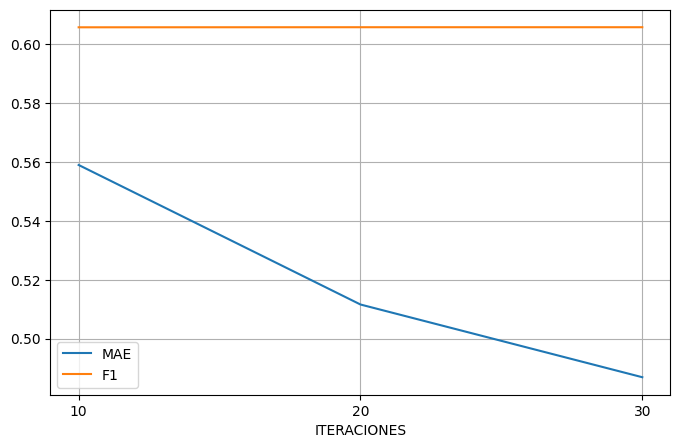

In [ ]:
x = [10, 20, 30]

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('ITERACIONES')
plt.legend()
plt.grid(True)

plt.show()

El error se reduce hasta las 30 iteraciones, punto a partir del cual la disminución del error se equilibra y vale la pena añadir más iteraciones. Por tanto, el modelo se optimiza en `NUM_ITERACIONES = 30`.

### Ahora, vamos a obtener todas las métricas del modelo con los parámetros óptimos:

In [ ]:
NUM_FACTORS = 7
LEARNING_RATE = 0.01
REGULARIZATION = 0.9

NUM_ITERATIONS = 30

In [ ]:
for it in range(NUM_ITERATIONS):
  print("Iteración " + str(it + 1) + " de " + str(NUM_ITERATIONS))

  for s in range(len(SCORES)):

    # update users
    for u in range(NUM_USERS):
      delta = np.zeros(NUM_FACTORS)
      for i in range(NUM_ITEMS):
        if ratings[u][i] != None:
          dot = np.dot(U[s][u], V[s][i])

          for f in range(NUM_FACTORS):
            if ratings[u][i] == SCORES[s]:
              delta[f] += (1 - logit(dot)) * V[s][i][f]
            else:
              delta[f] -= logit(dot) * V[s][i][f]

          for f in range(NUM_FACTORS):
            U[s][u][f] += LEARNING_RATE * (delta[f] - REGULARIZATION * U[s][u][f])

    # update items
    for i in range(NUM_ITEMS):
      theta = np.zeros(NUM_FACTORS)
      for u in range(NUM_USERS):
        if ratings[u][i] != None:
          dot = np.dot(U[s][u], V[s][i])

          for f in range(NUM_FACTORS):
            if ratings[u][i] == SCORES[s]:
              theta[f] += (1 - logit(dot)) * U[s][u][f]
            else:
              theta[f] -= logit(dot) * U[s][u][f]

          for f in range(NUM_FACTORS):
            V[s][i][f] += LEARNING_RATE * (theta[f] - REGULARIZATION * V[s][i][f])


Iteración 1 de 30
Iteración 2 de 30
Iteración 3 de 30
Iteración 4 de 30
Iteración 5 de 30
Iteración 6 de 30
Iteración 7 de 30
Iteración 8 de 30
Iteración 9 de 30
Iteración 10 de 30
Iteración 11 de 30
Iteración 12 de 30
Iteración 13 de 30
Iteración 14 de 30
Iteración 15 de 30
Iteración 16 de 30
Iteración 17 de 30
Iteración 18 de 30
Iteración 19 de 30
Iteración 20 de 30
Iteración 21 de 30
Iteración 22 de 30
Iteración 23 de 30
Iteración 24 de 30
Iteración 25 de 30
Iteración 26 de 30
Iteración 27 de 30
Iteración 28 de 30
Iteración 29 de 30
Iteración 30 de 30


In [ ]:
theta = 4

mae = get_mae(predictions)
rmse = get_rmse(predictions)
precision = get_precision(predictions)
recall = get_recall(predictions)
f1 = get_f1(predictions)
ndcg = get_ndcg(predictions)
print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))
print("nDCG = " + str(ndcg))

MAE = 0.48693133533015365
RMSE = 0.8244578624981632
Precision = 0.9154649947753403
Recall = 0.5617567291215209
F1 = 0.6057182420755144
nDCG = 0.5100232795853001


## Neural Collaborative Filtering

In [ ]:
# Importamos las librerías necesarias

from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense, Concatenate, Dot, Activation, Lambda
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Cargamos el dataset
data = pd.read_csv('ratings_bien.csv', engine= 'python')
data.sort_values(by=('user_id'), inplace= True)
data.reset_index(inplace= True, drop= True)
data

,user_id,item_id,rating,timestamp
0,0,122339,5.0,1485216000
1,0,44777,4.0,1449360000
2,0,107972,5.0,1421280000
3,0,97552,5.0,1390262400
4,1,26825,5.0,1289865600
...,...,...,...,...
147131,1547,96038,5.0,1513209600
147132,1547,8286,5.0,1513900800
147133,1547,41056,5.0,1514160000
147134,1547,115290,5.0,1510963200


Ahora vamos a dividir el dataset en dos matrices de votaciones y votaciones de test.

In [ ]:
# Dividimos en 80% para entrenamiento, 20% para test
X_train = data.sample(int(0.8 * data.shape[0]), random_state= 42)
X_test = data.loc[np.setdiff1d(data.index, X_train.index), :]


In [ ]:
data_train = X_train
data_test = X_test

In [ ]:
# Datos de entrenamiento
X_train = [np.array([], dtype=int), np.array([], dtype=int)]
y_train = np.array([], dtype=int)

for idx, row in data_train.iterrows():
    u, i, rating = row['user_id'], row['item_id'], row['rating']
    X_train[0] = np.append(X_train[0], int(u))
    X_train[1] = np.append(X_train[1], int(i))
    y_train = np.append(y_train, int(rating))

In [ ]:
# Datos de test
X_test = [np.array([], dtype=int), np.array([], dtype=int)]
y_test = np.array([], dtype=int)

for idx, row in data_test.iterrows():
    u, i, rating = row['user_id'], row['item_id'], row['rating']
    X_test[0] = np.append(X_test[0], int(u))
    X_test[1] = np.append(X_test[1], int(i))
    y_test = np.append(y_test, int(rating))

Una vez divido el dataset en entrenamiento y test, vamos a pasar a probar los diferentes métodos:

### Generalized Matrix Factorization

In [ ]:
latent_dim = 5
epochs = 10

In [ ]:
# Definimos la estructura del modelo
user_input = Input(shape=[1])
user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

output = Dot(axes=1)([user_vec, item_vec])
GMF = Model([user_input, item_input], output)


# Entrenamos el modelo
GMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
GMF.summary()
GMF.fit(X_train, y_train, epochs=epochs, verbose=1)


y_pred = GMF.predict(X_test)

# Redondeamos y_pred al valor más cercano para calcular las métricas de precision, recall y f1
y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
y_pred_round

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 5)      │      7,740 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 5)      │    644,385 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 5)         │          0 │ embedding_10[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 5)         │          0 │ embedding_11[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 652,125 (2.49 MB)

 Trainable params: 652,125 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_35', 'keras_tensor_38']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3679/3679 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 22.7690 - mae: 4.6769
Epoch 2/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 22.4170 - mae: 4.6379
Epoch 3/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 19.7140 - mae: 4.3260
Epoch 4/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 14.5139 - mae: 3.6218
Epoch 5/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 9.5261 - mae: 2.7259
Epoch 6/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 6.0471 - mae: 1.9582
Epoch 7/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 3.9117 - mae: 1.4490
Epoch 8/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 2.6311 - mae: 1.1177
Epoch 9/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 1.7973 - mae: 0.8779
Epoch 10/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 1.3342 - mae: 0.7339


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
precision = precision_score(y_test, y_pred_round, average='macro')
recall = recall_score(y_test, y_pred_round, average='macro')
f1 = f1_score(y_test, y_pred_round, average='macro')

print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))

MAE = 4.480851933396575
RMSE = 4.7279768030282545
Precision = 0.21868724882802656
Recall = 0.21154188528194912
F1 = 0.03966921560445984


Comparando el error MAE de los datos de entrenamiento con los datos de test, obtenemos un gran contraste ya que mientras el MAE en el entrenamiento es de 0.73, el del test es de 4.48. Esto puede indicar que el modelo se está sobreajustando.

Vamos a modificar el modelo añadiendo una capa de activación sigmoide y asegurarnos de que el modelo devuelve valores entre 1 y 5.

In [ ]:
user_input = Input(shape=[1])
user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

dot = Dot(axes=1)([user_vec, item_vec])

# Capa de activación
output = Activation('sigmoid')(dot)
output = Lambda(lambda x: x * 4 + 1)(output) # Valores entre 1 y 5

GMF = Model([user_input, item_input], output)


# Entrenamos el modelo
GMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
GMF.summary()
GMF.fit(X_train, y_train, epochs=epochs, verbose=1)


y_pred = GMF.predict(X_test)

# Redondeamos y_pred al valor más cercano para calcular las métricas de precision, recall y f1
y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
y_pred_round

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
precision = precision_score(y_test, y_pred_round, average='macro')
recall = recall_score(y_test, y_pred_round, average='macro')
f1 = f1_score(y_test, y_pred_round, average='macro')

print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))

MAE = 1.8176509327209238
RMSE = 1.9568731081104456
Precision = 0.22034206596217593
Recall = 0.21990608939982334
F1 = 0.05875245525484862


Con la modificación de la capa activación, el error se reduce notablemente y la precisión, recall y F1 mejoran ligeramente. Vamos a intentar reducir el error optimizando los parámetros.

### Factores latentes

In [ ]:
list_mae = []
list_f1 = []

for latent_dim in list(range(4, 11)):
    user_input = Input(shape=[1])
    user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    item_input = Input(shape=[1])
    item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
    item_vec = Flatten()(item_embedding)

    dot = Dot(axes=1)([user_vec, item_vec])

    # Capa de activación
    output = Activation('sigmoid')(dot)
    output = Lambda(lambda x: x * 4 + 1)(output)

    GMF = Model([user_input, item_input], output)


    # Entrenamos el modelo
    GMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    GMF.fit(X_train, y_train, epochs=epochs, verbose=0)


    y_pred = GMF.predict(X_test)
    # Redondeamos y_pred al valor más cercano para calcular las métricas de precision
    y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)


    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred_round, average='macro')
    list_mae.append(mae)
    list_f1.append(f1)

c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_53', 'keras_tensor_56']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_64', 'keras_tensor_67']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_78']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_86', 'keras_tensor_89']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_97', 'keras_tensor_100']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_108', 'keras_tensor_111']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


c:\Users\jcarr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_119', 'keras_tensor_122']. Received: the structure of inputs=('*', '*')
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


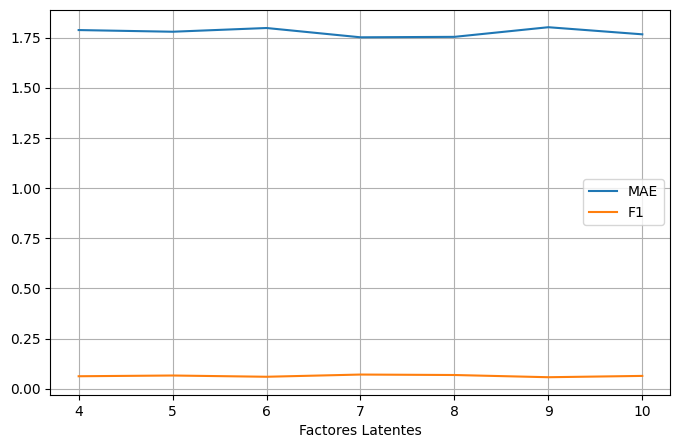

In [ ]:
x = list(range(4, 11))

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('Factores Latentes')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
print(f'Errores MAE')
dict(sorted({i: j for i, j in zip(list(range(4, 11)), list_mae)}.items(), key=lambda item: item[1], reverse=False))

Errores MAE


{7: 1.7510351799210728,
 8: 1.7532775695717366,
 10: 1.7658646874645247,
 5: 1.7787774103773795,
 4: 1.7871166090367685,
 6: 1.7973303352261718,
 9: 1.8012618371183593}

In [ ]:
print(f'F1 Score')
dict(sorted({i: j for i, j in zip(list(range(4, 11)), list_f1)}.items(), key=lambda item: item[1], reverse=True))

F1 Score


{7: 0.07044832545151826,
 8: 0.06816506522406429,
 5: 0.06567818866228818,
 10: 0.06368093950345206,
 4: 0.06201162527810896,
 6: 0.05945204786434087,
 9: 0.057144376773335545}

Obtenemos los mejores resultados con `7 factores latentes`.

### Epochs

In [ ]:
list_mae = []
list_f1 = []
latent_dim = 7

for epochs in list(range(5, 16)):
    user_input = Input(shape=[1])
    user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    item_input = Input(shape=[1])
    item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
    item_vec = Flatten()(item_embedding)

    dot = Dot(axes=1)([user_vec, item_vec])

    # Capa de activación
    output = Activation('sigmoid')(dot)
    output = Lambda(lambda x: x * 4 + 1)(output)

    GMF = Model([user_input, item_input], output)


    # Entrenamos el modelo
    GMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    GMF.fit(X_train, y_train, epochs=epochs, verbose=0)


    y_pred = GMF.predict(X_test)
    # Redondeamos y_pred al valor más cercano para calcular las métricas de precision
    y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
    y_pred_round


    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred_round, average='macro')
    list_mae.append(mae)
    list_f1.append(f1)


920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step


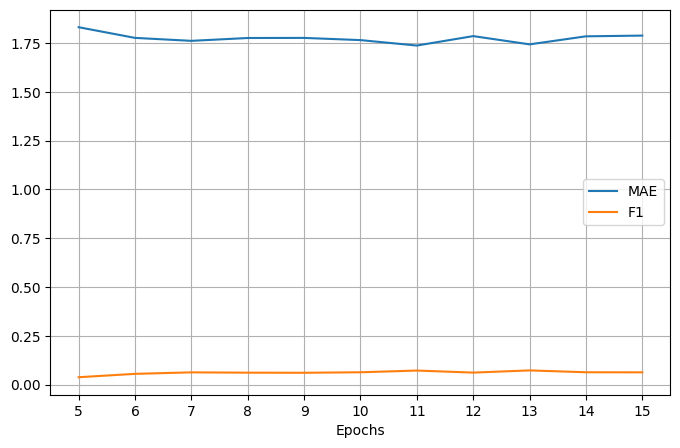

In [ ]:
x = list(range(5, 16))

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
print(f'Errores MAE')
dict(sorted({i: j for i, j in zip(list(range(5, 16)), list_mae)}.items(), key=lambda item: item[1], reverse=False))

Errores MAE


{11: 1.7366455793380737,
 13: 1.7427388429641724,
 7: 1.7607262134552002,
 10: 1.7645498514175415,
 8: 1.775308609008789,
 9: 1.7758047580718994,
 6: 1.7758793830871582,
 14: 1.7839114665985107,
 12: 1.7850351333618164,
 15: 1.7876464128494263,
 5: 1.8305203914642334}

In [ ]:
print(f'F1 Score')
dict(sorted({i: j for i, j in zip(list(range(5, 16)), list_f1)}.items(), key=lambda item: item[1], reverse=True))

F1 Score


{13: 0.07263510813988286,
 11: 0.07188441971498111,
 14: 0.06315638891519859,
 10: 0.06312760210281923,
 15: 0.06276575414306336,
 7: 0.06265448271885546,
 12: 0.061396033328623464,
 8: 0.06104639000335675,
 9: 0.060525621707347564,
 6: 0.05500787898136441,
 5: 0.03773776189038798}

Obtenemos el menor error con `11 epochs`.

### Ahora, vamos a obtener todas las métricas del modelo con los parámetros óptimos:

In [ ]:
latent_dim = 7
epochs = 11

In [ ]:
user_input = Input(shape=[1])
user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

dot = Dot(axes=1)([user_vec, item_vec])

# Capa de activación
output = Activation('sigmoid')(dot)
output = Lambda(lambda x: x * 4 + 1)(output)

GMF = Model([user_input, item_input], output)


# Entrenamos el modelo
GMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
GMF.fit(X_train, y_train, epochs=epochs, verbose=1)


y_pred = GMF.predict(X_test)
# Redondeamos y_pred al valor más cercano para calcular las métricas de precision
y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
y_pred_round

Epoch 1/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.7129 - mae: 1.8913
Epoch 2/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.5451 - mae: 1.8463
Epoch 3/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.4174 - mae: 1.4928
Epoch 4/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.1925 - mae: 0.9630
Epoch 5/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.5553 - mae: 0.5785
Epoch 6/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2764 - mae: 0.3602
Epoch 7/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1531 - mae: 0.2360
Epoch 8/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0916 - mae: 0.1614
Epoch 9/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0599 - mae: 0.1171
Epoch 10/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0428 - mae: 0.0880
Epoch 11/11
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0330 - mae: 0.0711
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step


array([[3],
       [3],
       [3],
       ...,
       [3],
       [3],
       [3]])

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
precision = precision_score(y_test, y_pred_round, average='macro')
recall = recall_score(y_test, y_pred_round, average='macro')
f1 = f1_score(y_test, y_pred_round, average='macro')

print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))

MAE = 1.777532696723938
RMSE = 1.9208537544053135
Precision = 0.22021724974473714
Recall = 0.21704513418127677
F1 = 0.0620890893679001


Las métricas no son muy buenas por lo que intentaremos mejorarlo con Multi Layer Perceptron.

### Multi Layer Perceptron

In [ ]:
latent_dim = 5
epochs = 10

In [ ]:
# Definimos la estructura del modelo
user_input = Input(shape=[1])
user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

concat = Concatenate(axis=1)([user_vec, item_vec])

dense1 = Dense(20, activation='relu')(concat)
dense2 = Dense(10, activation='relu')(dense1)
output = Dense(1, activation='relu')(dense2)

MLP = Model([user_input, item_input], output)


# Entrenamos el modelo
MLP.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
MLP.summary()
MLP.fit(X_train, y_train, epochs=epochs, verbose=1)


y_pred = MLP.predict(X_test)

# Redondeamos y_pred al valor más cercano para calcular las métricas de precision
y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
y_pred_round

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 1, 5)      │      7,740 │ input_layer_24[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, 1, 5)      │    644,385 │ input_layer_25[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 5)         │          0 │ embedding_24[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 5)         │          0 │ embedding_25[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ flatten_24[0][0], │
│ (Concatenate)       │                   │            │ flatten_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        220 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        210 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         11 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 652,566 (2.49 MB)

 Trainable params: 652,566 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.8320 - mae: 1.2104
Epoch 2/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.4557 - mae: 0.3238
Epoch 3/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1604 - mae: 0.1718
Epoch 4/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0869 - mae: 0.1201
Epoch 5/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0863 - mae: 0.1241
Epoch 6/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0596 - mae: 0.0978
Epoch 7/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0576 - mae: 0.0941
Epoch 8/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0517 - mae: 0.0868
Epoch 9/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0490 - mae: 0.0853
Epoch 10/10
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0454 - mae: 0.0837
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


array([[4],
       [4],
       [4],
       ...,
       [5],
       [4],
       [5]])

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
precision = precision_score(y_test, y_pred_round, average='macro')
recall = recall_score(y_test, y_pred_round, average='macro')
f1 = f1_score(y_test, y_pred_round, average='macro')

print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))

MAE = 0.6294637322425842
RMSE = 0.9968580417924598
Precision = 0.31436686898308264
Recall = 0.23429113436757767
F1 = 0.19923609220109895


A primera vista, los resultados son mucho mejores que los del primer modelo. Vamos a obtener los parámetros óptimos:

### Número de neuronas

In [ ]:
latent_dim = 5
epochs = 10

In [ ]:
list_mae = []
list_f1 = []

for num_neuronas in list(range(10, 31)):
    # Definimos la estructura del modelo
    user_input = Input(shape=[1])
    user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    item_input = Input(shape=[1])
    item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
    item_vec = Flatten()(item_embedding)

    concat = Concatenate(axis=1)([user_vec, item_vec])

    dense1 = Dense(2 * num_neuronas, activation='relu')(concat)
    dense2 = Dense(num_neuronas, activation='relu')(dense1)
    output = Dense(1, activation='relu')(dense2)

    MLP = Model([user_input, item_input], output)


    # Entrenamos el modelo
    MLP.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    MLP.fit(X_train, y_train, epochs=epochs, verbose=0)


    y_pred = MLP.predict(X_test)

    # Redondeamos y_pred al valor más cercano para calcular las métricas de precision
    y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
    y_pred_round


    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred_round, average='macro')
    list_mae.append(mae)
    list_f1.append(f1)

920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step


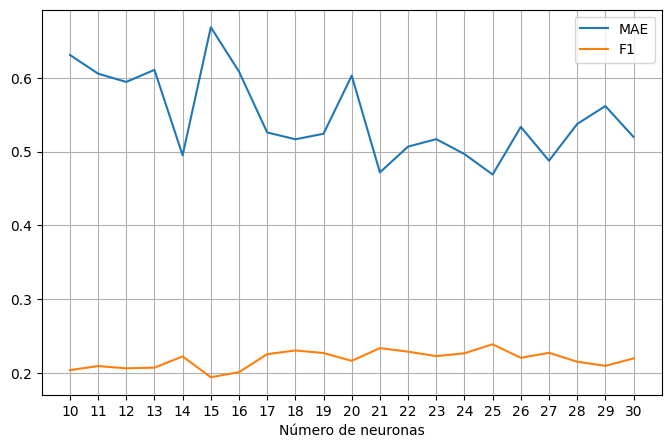

In [ ]:
x = list(range(10, 31))

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('Número de neuronas')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
print(f'Errores MAE')
dict(sorted({i: j for i, j in zip(list(range(10, 31)), list_mae)}.items(), key=lambda item: item[1], reverse=False))

Errores MAE


{25: 0.4688701033592224,
 21: 0.4717331826686859,
 27: 0.4875997006893158,
 14: 0.4949502646923065,
 24: 0.496624618768692,
 22: 0.5067633986473083,
 18: 0.5166705250740051,
 23: 0.5168584585189819,
 30: 0.5198178887367249,
 19: 0.5241408944129944,
 17: 0.5259590744972229,
 26: 0.5334790349006653,
 28: 0.5374205708503723,
 29: 0.5617421865463257,
 12: 0.5944446921348572,
 20: 0.602968692779541,
 11: 0.6056764125823975,
 16: 0.608504056930542,
 13: 0.6108028292655945,
 10: 0.6311082243919373,
 15: 0.6686414480209351}

In [ ]:
print(f'F1 Score')
dict(sorted({i: j for i, j in zip(list(range(10, 31)), list_f1)}.items(), key=lambda item: item[1], reverse=True))

F1 Score


{25: 0.23861184424462553,
 21: 0.23346772247679634,
 18: 0.23028433126845443,
 22: 0.22863142882567353,
 27: 0.22709214311423773,
 19: 0.2267909313451865,
 24: 0.22649683566207965,
 17: 0.2252111990931907,
 23: 0.22255744176146125,
 14: 0.22217880211374733,
 26: 0.22032591397169546,
 30: 0.21947873155553183,
 20: 0.2161768729505536,
 28: 0.21499780076837816,
 29: 0.20941940514861296,
 11: 0.20910570713765986,
 13: 0.206960176395051,
 12: 0.20607515368451113,
 10: 0.20364478934125446,
 16: 0.2008449521620692,
 15: 0.1939756521357854}

Obtenemos los mejores resultados con `50 y 25 neuronas`.

### Factores latentes

In [ ]:
num_neuronas = 25

In [ ]:
list_mae = []
list_f1 = []

for latent_dim in list(range(10, 21)):
    # Definimos la estructura del modelo
    user_input = Input(shape=[1])
    user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    item_input = Input(shape=[1])
    item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
    item_vec = Flatten()(item_embedding)

    concat = Concatenate(axis=1)([user_vec, item_vec])

    dense1 = Dense(2 * num_neuronas, activation='relu')(concat)
    dense2 = Dense(num_neuronas, activation='relu')(dense1)
    output = Dense(1, activation='relu')(dense2)

    MLP = Model([user_input, item_input], output)


    # Entrenamos el modelo
    MLP.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    MLP.fit(X_train, y_train, epochs=epochs, verbose=0)


    y_pred = MLP.predict(X_test)

    # Redondeamos y_pred al valor más cercano para calcular las métricas de precision
    y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
    y_pred_round


    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred_round, average='macro')
    list_mae.append(mae)
    list_f1.append(f1)

920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 583us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step


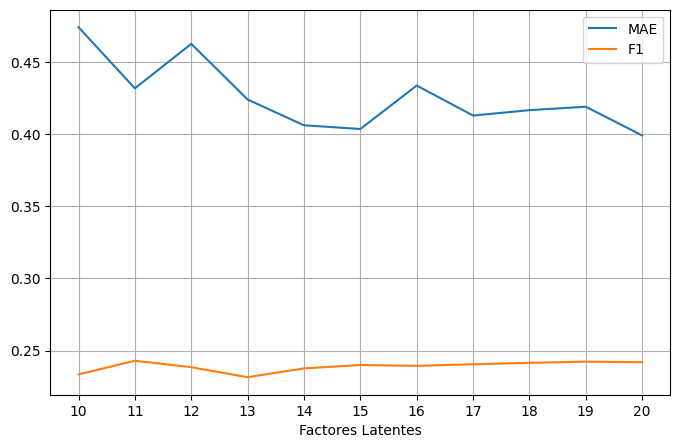

In [ ]:
x = list(range(10, 21))

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('Factores Latentes')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
print(f'Errores MAE')
dict(sorted({i: j for i, j in zip(list(range(10, 21)), list_mae)}.items(), key=lambda item: item[1], reverse=False))

Errores MAE


{20: 0.3991354703903198,
 15: 0.4036027789115906,
 14: 0.40617576241493225,
 17: 0.41292545199394226,
 18: 0.41666460037231445,
 19: 0.41902726888656616,
 13: 0.4240463376045227,
 11: 0.43176448345184326,
 16: 0.4337216019630432,
 12: 0.4626433253288269,
 10: 0.4741651713848114}

In [ ]:
print(f'F1 Score')
dict(sorted({i: j for i, j in zip(list(range(10, 21)), list_f1)}.items(), key=lambda item: item[1], reverse=True))

F1 Score


{11: 0.24289309869887904,
 19: 0.2422785446619277,
 20: 0.24188545497778158,
 18: 0.24146006072899479,
 17: 0.2404697574220874,
 15: 0.23994144590444,
 16: 0.2393786631429502,
 12: 0.2384369493712939,
 14: 0.2375909845182993,
 10: 0.23340581103209748,
 13: 0.23148229984611923}

Parece que obtenemos los mejores resultados con `20 factores latentes`.

### Epochs

In [ ]:
list_mae = []
list_f1 = []
latent_dim = 20
num_neuronas = 25

for epochs in list(range(10, 21)):
    # Definimos la estructura del modelo
    user_input = Input(shape=[1])
    user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    item_input = Input(shape=[1])
    item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
    item_vec = Flatten()(item_embedding)

    concat = Concatenate(axis=1)([user_vec, item_vec])

    dense1 = Dense(2 * num_neuronas, activation='relu')(concat)
    dense2 = Dense(num_neuronas, activation='relu')(dense1)
    output = Dense(1, activation='relu')(dense2)

    MLP = Model([user_input, item_input], output)


    # Entrenamos el modelo
    MLP.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    MLP.fit(X_train, y_train, epochs=epochs, verbose=0)


    y_pred = MLP.predict(X_test)

    # Redondeamos y_pred al valor más cercano para calcular las métricas de precision
    y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
    y_pred_round


    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred_round, average='macro')
    list_mae.append(mae)
    list_f1.append(f1)

920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step


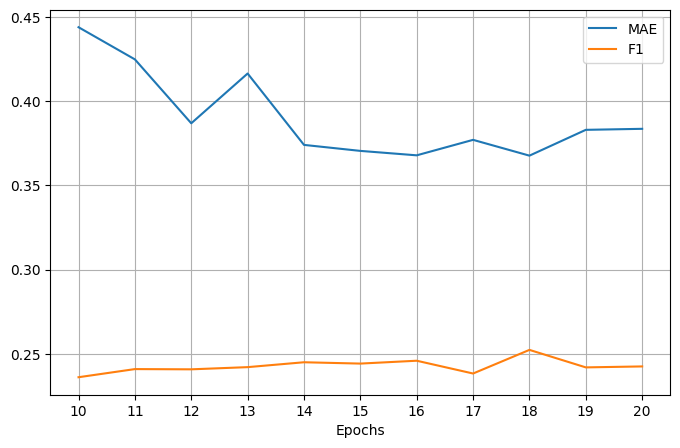

In [ ]:
x = list(range(10, 21))

plt.figure(figsize=(8, 5))
plt.plot(x, list_mae, label='MAE')
plt.plot(x, list_f1, label='F1')

plt.xticks(x)
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
print(f'Errores MAE')
dict(sorted({i: j for i, j in zip(list(range(10, 21)), list_mae)}.items(), key=lambda item: item[1], reverse=False))

Errores MAE


{18: 0.3676146864891052,
 16: 0.36780527234077454,
 15: 0.3704386353492737,
 14: 0.3739967942237854,
 17: 0.37699657678604126,
 19: 0.3829379677772522,
 20: 0.38354378938674927,
 12: 0.3868330121040344,
 13: 0.41638311743736267,
 11: 0.42477142810821533,
 10: 0.4438686966896057}

In [ ]:
print(f'F1 Score')
dict(sorted({i: j for i, j in zip(list(range(10, 21)), list_f1)}.items(), key=lambda item: item[1], reverse=True))

F1 Score


{18: 0.25227964661889535,
 16: 0.24584513726015506,
 14: 0.24493755989136537,
 15: 0.24414917283650225,
 20: 0.24246068295575016,
 13: 0.24203873653911065,
 19: 0.24189196939904622,
 11: 0.24087894322248835,
 12: 0.24074025771393295,
 17: 0.2382532151062776,
 10: 0.236052901165655}

Obtenemos el menor error con `18 epochs`.

### Ahora, vamos a obtener todas las métricas del modelo con los parámetros óptimos:

In [ ]:
latent_dim = 20
epochs = 18
num_neuronas = 25

In [ ]:
# Definimos la estructura del modelo
user_input = Input(shape=[1])
user_embedding = Embedding(NUM_USERS, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(NUM_ITEMS, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

concat = Concatenate(axis=1)([user_vec, item_vec])

dense1 = Dense(2 * num_neuronas, activation='relu')(concat)
dense2 = Dense(num_neuronas, activation='relu')(dense1)
output = Dense(1, activation='relu')(dense2)

MLP = Model([user_input, item_input], output)


# Entrenamos el modelo
MLP.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
MLP.fit(X_train, y_train, epochs=epochs, verbose=1)


y_pred = MLP.predict(X_test)

# Redondeamos y_pred al valor más cercano para calcular las métricas de precision
y_pred_round = np.clip(np.round(y_pred), 1, 5).astype(int)
y_pred_round

Epoch 1/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.8355 - mae: 0.9792
Epoch 2/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3873 - mae: 0.2989
Epoch 3/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.1460 - mae: 0.1772
Epoch 4/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0764 - mae: 0.1129
Epoch 5/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0753 - mae: 0.1154
Epoch 6/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0659 - mae: 0.1050
Epoch 7/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0578 - mae: 0.0997
Epoch 8/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0495 - mae: 0.0910
Epoch 9/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0485 - mae: 0.0897
Epoch 10/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0415 - mae: 0.0809
Epoch 11/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0360 - mae: 0.0730
Epoch 12/18
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0348 - mae: 0.07

array([[4],
       [4],
       [3],
       ...,
       [5],
       [5],
       [5]])

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
precision = precision_score(y_test, y_pred_round, average='macro')
recall = recall_score(y_test, y_pred_round, average='macro')
f1 = f1_score(y_test, y_pred_round, average='macro')

print("MAE = " + str(mae))
print("RMSE = " + str(rmse))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 = " + str(f1))

MAE = 0.38791021704673767
RMSE = 0.9821829837181838
Precision = 0.3713346854198785
Recall = 0.23314191253710934
F1 = 0.23919003411591327


Una vez probados los dos modelos basados en redes neuronales, podemos concluir que el modelo de `Multi Layer Perceptron` obtiene unos resultados muy superiores a los de `Generalized Matrix Factorization`.